In [1]:
import math
from typing import *

import pandas as pd
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

import lass.datasets
import lass.pipeline
from lass.log_handling import LogLoader, LogLoaderArgs, PaperTasks

from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from scipy.special import kl_div

In [2]:


eps = np.finfo(float).eps

# Cases 5 classes
cases = [
    [1.00, 0.00, 0.00, 0.00, 0.00],
    [0.00, 1.00, 0.00, 0.00, 0.00],
    [0.00, 0.5, 0.5, 0.00, 0.00],
    [0.96, 0.01, 0.01, 0.01, 0.01],
    [0.96, 0.04, 0.00, 0.00, 0.00],
    [0.51, 0.49, 0.00, 0.00, 0.00],
    [0.50, 0.50, 0.00, 0.00, 0.00],
    [0.50, 0.125, 0.125, 0.125, 0.125],
    [0.20, 0.20, 0.20, 0.20, 0.20],
    [0.20, 0.80, 0.00, 0.00, 0.00],
    [0.24, 0.19, 0.19, 0.19, 0.19],
]

print("Log Loss")
for case in cases:
    print(f"{log_loss([1], [case], labels=[1, 2, 3, 4, 5]):.8f}", case)

# print("Brier scores")
# for case in cases:
#     print(f"{brier_score_loss([1], [case[0]]):.8f}", case)

print("Kullback-Leibler Divergence")
for case in cases:
    print(f"{kl_div([1, 0, 0, 0, 0], [case]).sum():.8f}", case)

# print("-----")
# for case in cases:
#     own_loss = lambda y_true, y_pred: -sum((idx==y_true-1)*math.log(p+eps) for idx, p in enumerate(y_pred))
#     own_loss2 = lambda y_true, y_pred: -math.log(y_pred[y_true-1]+eps)
#     print(f"{own_loss(1, case):.8f}", case)
#     print(f"{own_loss2(1, case):.8f}", case)

Log Loss
0.00000000 [1.0, 0.0, 0.0, 0.0, 0.0]
34.53877639 [0.0, 1.0, 0.0, 0.0, 0.0]
34.53877639 [0.0, 0.5, 0.5, 0.0, 0.0]
0.04082199 [0.96, 0.01, 0.01, 0.01, 0.01]
0.04082199 [0.96, 0.04, 0.0, 0.0, 0.0]
0.67334455 [0.51, 0.49, 0.0, 0.0, 0.0]
0.69314718 [0.5, 0.5, 0.0, 0.0, 0.0]
0.69314718 [0.5, 0.125, 0.125, 0.125, 0.125]
1.60943791 [0.2, 0.2, 0.2, 0.2, 0.2]
1.60943791 [0.2, 0.8, 0.0, 0.0, 0.0]
1.42711636 [0.24, 0.19, 0.19, 0.19, 0.19]
Kullback-Leibler Divergence
0.00000000 [1.0, 0.0, 0.0, 0.0, 0.0]
inf [0.0, 1.0, 0.0, 0.0, 0.0]
inf [0.0, 0.5, 0.5, 0.0, 0.0]
0.04082199 [0.96, 0.01, 0.01, 0.01, 0.01]
0.04082199 [0.96, 0.04, 0.0, 0.0, 0.0]
0.67334455 [0.51, 0.49, 0.0, 0.0, 0.0]
0.69314718 [0.5, 0.5, 0.0, 0.0, 0.0]
0.69314718 [0.5, 0.125, 0.125, 0.125, 0.125]
1.60943791 [0.2, 0.2, 0.2, 0.2, 0.2]
1.60943791 [0.2, 0.8, 0.0, 0.0, 0.0]
1.42711636 [0.24, 0.19, 0.19, 0.19, 0.19]


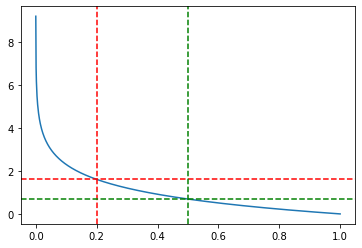

In [3]:
def log_loss_to_decision():
    x = np.linspace(0.0001, 1, 1000)
    y = -np.log(x)
    plt.plot(x, y)
    plt.axvline(0.2, color="red", linestyle="--")
    plt.axhline(-np.log(0.2), color="red", linestyle="--")
    plt.axvline(0.5, color="green", linestyle="--")
    plt.axhline(-np.log(0.5), color="green", linestyle="--")

log_loss_to_decision()

In [4]:
np.log(0.49)

-0.7133498878774648

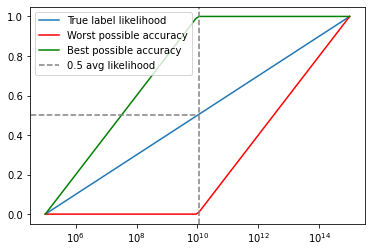

In [5]:
n_classes = 5
n_models = 100
def metric_pressure2():
    x = np.logspace(5, 15, n_models)
    y = np.linspace(0, 1, n_models) # + np.random.normal(0, 0.02, len(x)) # Typical acc performance curve
    
    # TODO: Put this on plot with likelihood the X-axis, and accuracy the Y-axis

    # 0.50-eps is the worst failure, 1.00 is the worst success (as in, takes up the most)
    # Likelihood = percent_failures*0.5 + percent_successes*1
    # with percent_failures + percent_successes = 1
    # Solving gives:
    #   percent_successes = 2*(likelihood-0.5)
    #   percent_failures = 2*(1-likelihood)
    # Accuracy = percent_successes = 2*(likelihood-0.5)
    acc_worst = 2*(np.clip(y, 0.5, 1)-0.5)

    # 0.0 is the best failure, 0.50 is the best success (as in, takes up the least)
    # WRONG WRONG: 0.5 is only best in binary case, not in multi-class case
    # Solving gives (WRONG):
    #  percent_successes = 2*(likelihood)
    #  percent_failures = 2*(0.5-likelihood)
    # Accuracy = percent_successes = 2*(likelihood)
    acc_best = np.clip(2*y, 0, 1)

    # y_log_best = (y)*np.log(1)+(1-y)*np.log(0.49)
    fig, ax1 = plt.subplots()

    ax1.plot(x, y, label="True label likelihood")
    ax1.set_xscale("log")
    ax1.set_yscale("linear")
    ax1.set_ylim(-0.05, 1.05)
    
    ax1.plot(x, acc_worst, color="red", label="Worst possible accuracy")
    ax1.plot(x, acc_best, color="green", label="Best possible accuracy")
    ax1.plot((0, x[np.argmax(y>=0.5)]), (0.5, 0.5), "--", color="grey",)
    ax1.axvline(x[np.argmax(y>=0.5)], color="grey", linestyle="--", label="0.5 avg likelihood")
    ax1.legend()

metric_pressure2()

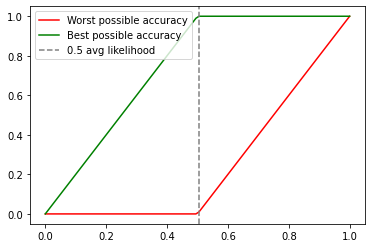

In [6]:
def metric_pressure3():
    n_likelihoods = 100
    x = np.linspace(0, 1, n_likelihoods) # likelihood
    y = np.linspace(0, 1, n_likelihoods) # accuracy
    acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
    acc_best = np.clip(2*x, 0, 1)
    fig, ax1 = plt.subplots()

    ax1.set_ylim(-0.05, 1.05)
    ax1.plot(x, acc_worst, color="red", label="Worst possible accuracy")
    ax1.plot(x, acc_best, color="green", label="Best possible accuracy")
    # ax1.plot((0, x[np.argmax(x>=0.5)]), (0.5, 0.5), "--", color="grey",)
    ax1.axvline(x[np.argmax(x>=0.5)], color="grey", linestyle="--", label="0.5 avg likelihood")
    ax1.legend()

metric_pressure3()

In [7]:
MODEL_SIZES = {
    "2m": 2098048,
    "16m": 16780288,
    "53m": 56629632,
    "125m": 134228992,
    "244m": 262161280,
    "422m": 453009408,
    "1b": 1073784832,
    "2b": 2097218560,
    "4b": 3623973888,
    "8b": 8590102528,
    "27b": 28991404032,
    "128b": 137440272384,
}

In [8]:
loader_args = LogLoaderArgs(
    logdir='../artifacts/logs',
    # tasks='paper-full',
    tasks = PaperTasks.lite() + ['periodic_elements'],
    model_families=['BIG-G T=0'],
    # model_sizes=['128b'],
    query_types=['multiple_choice'],
    # shots=[0],
    include_unknown_shots=True,
    exclude_faulty_tasks=False,
)
loader = LogLoader(loader_args)

In [9]:
bigdf = lass.datasets.to_dataframe(loader)
bigdf = lass.pipeline.augment(bigdf)
bigdf = lass.pipeline.binarize(bigdf)
bigdf = lass.pipeline.clean(bigdf)
bigdf['parameters'] = bigdf.model_name.map(lambda name: MODEL_SIZES[name])

/home/wout/pp/lass/src/lass/pipeline.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[:, 'correct'] = df['correct'].astype(int)


In [10]:
def likelihood_of_correct_answer(row):
    # Indices of correct answers (there might be multiple)
    targets = [(idx, target) for idx, target in enumerate(row.targets) if row.target_values[target] == 1]
    if len(targets) == 0:
        return {}

    if len(targets) == 1:
        # Single correct answer
        idx, target = targets[0]
        return {
            'target_likelihood_normalized': row.normalized_scores[idx],
            'target_likelihood_absolute': row.absolute_scores[idx],
            'target_likelihood_normalized_char': row.normalized_scores[idx] / len(target),
            'target_likelihood_absolute_char': row.absolute_scores[idx] / len(target),
        }

    return {
        'target_likelihood_normalized': sum(row.normalized_scores[idx] for idx, _ in targets),
        'target_likelihood_absolute': sum(row.absolute_scores[idx] for idx, _ in targets),
        'target_likelihood_normalized_char': sum(row.normalized_scores[idx] / len(target) for idx, target in targets),
        'target_likelihood_absolute_char': sum(row.absolute_scores[idx] / len(target) for idx, target in targets),
    }

target_likelihoods = bigdf\
    .apply(likelihood_of_correct_answer, axis='columns', result_type='expand')
    # .rename(columns={0: 'target_likelihood_normalized', 1: 'target_likelihood_absolute'})
bigdf = pd.concat([bigdf, target_likelihoods], axis='columns')

In [11]:
# bigdf.query('task == "abstract_narrative_understanding"')
display(bigdf.model_name.unique())
display(bigdf.task.unique())

array(['2b', '53m', '16m', '125m', '1b', '128b', '4b', '422m', '27b',
       '244m', '2m', '8b'], dtype=object)

array(['bbq_lite_json', 'code_line_description',
       'conceptual_combinations', 'emoji_movie',
       'formal_fallacies_syllogisms_negation', 'hindu_knowledge',
       'known_unknowns', 'language_identification', 'logic_grid_puzzle',
       'logical_deduction', 'misconceptions_russian', 'novel_concepts',
       'play_dialog_same_or_different', 'strange_stories', 'strategyqa',
       'symbol_interpretation', 'vitaminc_fact_verification', 'winowhy',
       'periodic_elements'], dtype=object)

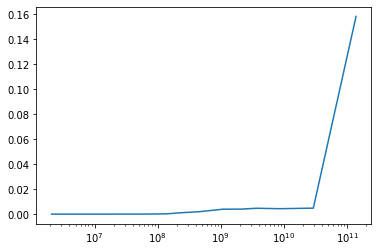

In [12]:
# Reproduce log-likelihood plots from paper first
# TODO: Did they take the logarithmic mean or not?
# grouped = bigdf.query('task == "bbq_lite_json"').groupby('model_name').mean()


def reproduce(df):
    grouped = df.groupby(['task', 'model_name']).mean()
    grouped = grouped.reset_index()

    fig, ax1 = plt.subplots()
    ax1.set_xscale("log")
    # ax1.set_ylim(-5, 0.05)
    # ax1.set_yscale("symlog")
    for task_name in grouped.task.unique()[:5]:
        task = grouped.query(f'task == "{task_name}"').sort_values('parameters')
        ax1.plot(task.parameters, np.exp(task.target_likelihood_normalized), label=task_name)
        # ax1.legend(loc='lower center')

        # acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
        # acc_best = np.clip(2*x, 0, 1)
        # fig, ax1 = plt.subplots()

        # ax1.set_ylim(-0.05, 1.05)
        # ax1.plot(x, acc_worst, color="red", label="Worst possible accuracy")
        # ax1.plot(x, acc_best, color="green", label="Best possible accuracy")
        # # ax1.plot((0, x[np.argmax(x>=0.5)]), (0.5, 0.5), "--", color="grey",)
        # ax1.axvline(x[np.argmax(x>=0.5)], color="grey", linestyle="--", label="0.5 avg likelihood")
        # ax1.legend()

# reproduce(bigdf)
reproduce(bigdf.query('task == "periodic_elements" and shots == 2'))
# grouped

In [13]:
def shot(df):
    grouped = df.groupby(['task', 'model_name', 'shots']).agg(
        correct=('correct', 'mean'),
        n_targets=('n_targets', 'mean'),
        parameters=('parameters', 'mean'), # should be only 1 value
        target_likelihood_normalized=('target_likelihood_normalized', lambda x: np.log(np.mean(np.exp(x)))),
    )
    grouped = grouped.reset_index()

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

    _ = ax1.set_ylabel("Likelihood"), ax1.set_xlabel("Parameters")
    _ = ax1.set_xscale("log")
    _ = ax2.set_ylabel("Accuracy"), ax2.set_xlabel("Parameters")
    _ = ax2.set_xscale("log")
    _ = ax3.set_ylabel("Accuracy"), ax3.set_xlabel("Likelihood")
    _ = ax3.set_xlim(0, 1)
    # _ = ax3.set_ylim(0, 0.4), ax3.set_xlim(0, 0.4)
    # ax1.set_ylim(-5, 0.05)
    # ax1.set_yscale("symlog")

    for task_name in grouped.task.unique()[:]:
        for shot in grouped.shots.unique():
            task = grouped.query(f'task == "{task_name}" and shots == {shot}').sort_values('parameters')

            # X-axis model size, Y-axis likelihood
            ax1.plot(task.parameters, np.exp(task.target_likelihood_normalized), label=f'{task_name} ({shot} shots)')
            ax1.legend(loc='upper center')

            # X-axis model size, Y-axis accuracy
            ax2.plot(task.parameters, task.correct, label=f'{task_name} ({shot} shots)')
            ax2.legend(loc='upper center')

            # X-axis likelihood, Y-axis accuracy
            ax3.plot(np.exp(task.target_likelihood_normalized), task.correct, label=f'{task_name} ({shot} shots)')

        x = np.linspace(0, 1, 100) # likelihood
        n_targets = grouped.query(f'task == "{task_name}"').n_targets.mean()
        # print(n_targets)
        acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
        acc_best = np.clip(x * n_targets, 0, 1)
        ax3.plot(x, acc_worst, color="red", label="Worst possible accuracy")
        ax3.plot(x, acc_best, color="green", label="Best possible accuracy")

# shot(bigdf)
# shot(bigdf.query('task == "periodic_elements"'))

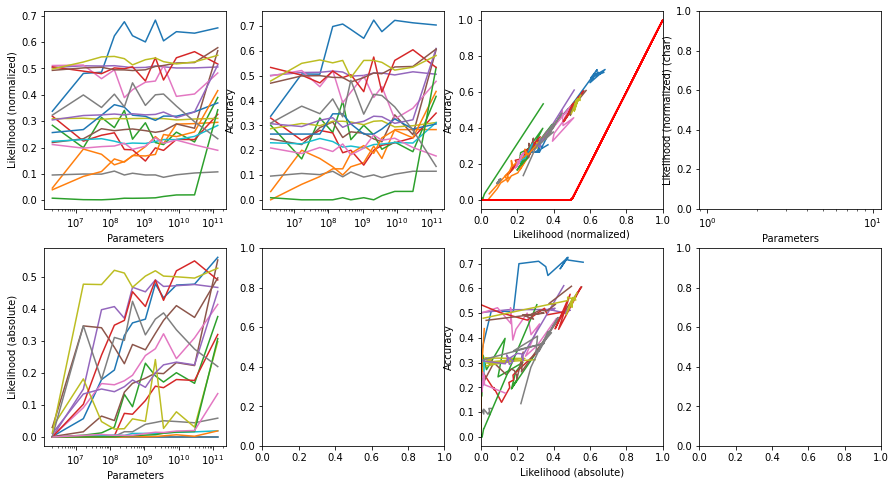

In [29]:
from matplotlib.axes import Axes

def multiplot(df, shots: Union[int, Literal["all"]]):
    # df['target_likelihood_normalized_char'] = df.target_likelihood_normalized.map()
    df = df.query(f'shots == {shots}') if shots != "all" else df
    grouped = df.groupby(['task', 'model_name']).agg(
        correct=('correct', 'mean'),
        n_targets=('n_targets', 'mean'),
        parameters=('parameters', 'mean'), # should be only 1 value
        target_likelihood_normalized=('target_likelihood_normalized', lambda x: np.log(np.mean(np.exp(x)))),
        target_likelihood_absolute=('target_likelihood_absolute', lambda x: np.log(np.mean(np.exp(x)))),
    )
    grouped = grouped.reset_index()

    fig, ((ax11, ax12, ax13, ax14), (ax21, ax22, ax23, ax24)) = plt.subplots(2, 4, figsize=(18, 8))

    _ = ax11.set_ylabel("Likelihood (normalized)"), ax11.set_xlabel("Parameters")
    _ = ax21.set_ylabel("Likelihood (absolute)"), ax21.set_xlabel("Parameters")
    _ = ax11.set_xscale("log")
    _ = ax21.set_xscale("log")
    _ = ax12.set_ylabel("Accuracy"), ax21.set_xlabel("Parameters")
    _ = ax12.set_xscale("log")
    _ = ax13.set_ylabel("Accuracy"), ax13.set_xlabel("Likelihood (normalized)")
    _ = ax13.set_xlim(0, 1)
    _ = ax23.set_ylabel("Accuracy"), ax23.set_xlabel("Likelihood (absolute)")
    _ = ax23.set_xlim(0, 1)
    _ = ax14.set_ylabel("Likelihood (normalized) (char)"), ax14.set_xlabel("Parameters")
    _ = ax14.set_xscale("log")
    # _ = ax3.set_ylim(0, 0.4), ax3.set_xlim(0, 0.4)
    # ax1.set_ylim(-5, 0.05)
    # ax1.set_yscale("symlog")

    for task_name in grouped.task.unique()[:]:
        task = grouped.query(f'task == "{task_name}"').sort_values('parameters')

        # X-axis model size, Y-axis likelihood
        ax11.plot(task.parameters, np.exp(task.target_likelihood_normalized), label=f'{task_name} ({shots} shots)')
        ax21.plot(task.parameters, np.exp(task.target_likelihood_absolute), label=f'{task_name} ({shots} shots)')
        # ax1.legend(loc='upper center')

        # X-axis model size, Y-axis accuracy
        ax12.plot(task.parameters, task.correct, label=f'{task_name} ({shots} shots)')
        # ax2.legend(loc='upper center')

        # X-axis likelihood, Y-axis accuracy
        ax13.plot(np.exp(task.target_likelihood_normalized), task.correct, label=f'{task_name} ({shots} shots)')
        ax23.plot(np.exp(task.target_likelihood_absolute), task.correct, label=f'{task_name} ({shots} shots)')

        x = np.linspace(0, 1, 100) # likelihood
        n_targets = grouped.query(f'task == "{task_name}"').n_targets.mean()
        # print(n_targets)
        acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
        acc_best = np.clip(x * n_targets, 0, 1)
        ax13.plot(x, acc_worst, color="red", label="Worst possible accuracy")
        # ax3.plot(x, acc_best, color="green", label="Best possible accuracy")

        # ax14.plot()

multiplot(bigdf, 3)


In [ ]:
bigdf.query('task == "periodic_elements"').n_targets.value_counts()

118    5664
Name: n_targets, dtype: int64

In [ ]:
# bigdf.query('task == "periodic_elements"').n_targets.value_counts()
bigdf.query('task == "bbq_lite_json"').n_targets.value_counts()
bigdf.query('task == "bbq_lite_json"').sort_values(['parameters', 'shots']).groupby(['model_name', 'shots'], sort=False).mean()
bigdf.query('task == "bbq_lite_json" and shots == 0 and model_name == "2m" and correct == 1.0').target_likelihood_normalized.map(np.exp).sort_values()
bigdf.query('task == "bbq_lite_json" and shots == 0 and model_name == "2m"').target_likelihood_normalized.map(np.exp).mean()

0.32929946045667124

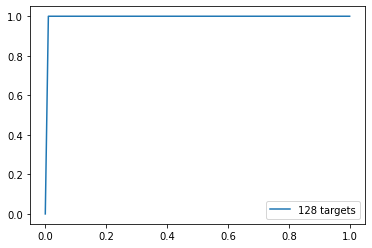

In [ ]:

def best_possible_accuracy():
    fig, ax1 = plt.subplots()
    # n_targetss = list(range(2, 20))
    n_targetss = [128]
    for n_targets in n_targetss:
        x = np.linspace(0, 1, 100) #likelihood

        # 0.0 is the 'best' failure, 1/n_targets + eps is the 'best' success (as in takes up the least of of the average likelihood)
        # Likelihood = percent_failures * 0.0 + percent_successes * (1/n_targets)
        # => percent_successes = likelihood / (1/n_targets)
        # => percent_successes = likelihood * n_targets
        # Capped at 1, since when the mean equals 1/n_targets, best possible accuracy is 1.
        acc_best = np.clip(x * n_targets, 0, 1)
        
        ax1.plot(x, acc_best, label=f'{n_targets} targets')
    ax1.legend(loc='lower right')

best_possible_accuracy()


# # 0.0 is the best failure, 0.50 is the best success (as in, takes up the least)
# # Solving gives (WRONG):
# #  percent_successes = 2*(likelihood)
# #  percent_failures = 2*(0.5-likelihood)
# # Accuracy = percent_successes = 2*(likelihood)
# acc_best = np.clip(2*y, 0, 1)

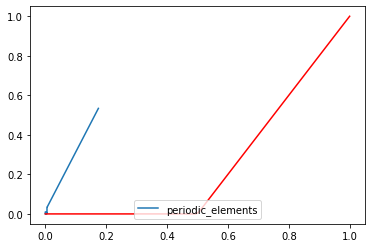

In [ ]:
def metric_pressure(df):
    # grouped = df.query('shots == 3').groupby(['task', 'model_name']).mean()
    grouped = df.groupby(['task', 'model_name']).mean()
    grouped = grouped.reset_index()

    fig, ax1 = plt.subplots()
    ax1.set_ylim(-0.05, 1.05)
    for task_name in grouped.task.unique()[:1]:
        task = grouped.query(f'task == "{task_name}"').sort_values('parameters')
        ax1.plot(np.exp(task.target_likelihood_normalized), task.correct, label=task_name)
        ax1.legend(loc='lower center')

        x = np.linspace(0, 1, 100) # likelihood
        acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
        ax1.plot(x, acc_worst, color="red", label="Worst possible accuracy")


metric_pressure(bigdf.query('task == "periodic_elements" and shots == 3'))
# metric_pressure(bigdf)

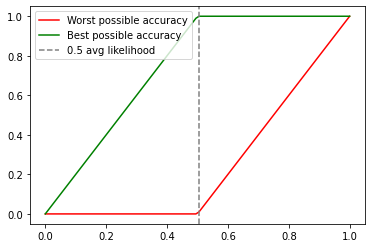

In [ ]:
def metric_pressure():
    n_likelihoods = 100
    x = np.linspace(0, 1, n_likelihoods) # likelihood
    y = np.linspace(0, 1, n_likelihoods) # accuracy
    acc_worst = 2*(np.clip(x, 0.5, 1)-0.5)
    acc_best = np.clip(2*x, 0, 1)
    fig, ax1 = plt.subplots()

    ax1.set_ylim(-0.05, 1.05)
    ax1.plot(x, acc_worst, color="red", label="Worst possible accuracy")
    ax1.plot(x, acc_best, color="green", label="Best possible accuracy")
    # ax1.plot((0, x[np.argmax(x>=0.5)]), (0.5, 0.5), "--", color="grey",)
    ax1.axvline(x[np.argmax(x>=0.5)], color="grey", linestyle="--", label="0.5 avg likelihood")
    ax1.legend()

metric_pressure()